In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

first, I load the .py file that contains the definition of the log likelihood (you need to make sure that you have the data in order to run this). Then I'll load two samplers, which operate in similar but meaningfully different ways (both of which I'll use in this notebook). Finally, I'll load the just-in-time compilation feature of jax, which is very useful (it's used many times in gce_highdim_model) and jax.numpy and numpy in case I need them

In [2]:
import gce_highdim_model as gm

import dynesty as dn
import numpyro as nr

from jax import jit
from jax import numpy as jnp
import numpy as np

be aware that jax has strong feelings about randomness -- for more of an explanation, see https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#random-numbers

In [3]:
import jax.random as jr
rng_key = jr.PRNGKey(0)

here is an example of how to use random number generation in practice

In [4]:
gm.jjlnprob(jr.uniform(rng_key,(19,))*(gm.pmax[:19]-gm.pmin[:19])+gm.pmin[:19], bin_no=5, ex_num=1)

DeviceArray(-1.30581384e+08, dtype=float32)

you ought to run "split" every time you want a new random number from the same distribution: note that the first two are identical, because we reused the key

In [5]:
rng_key, rng_key_ = jr.split(rng_key)

gm.jjlnprob(jr.uniform(rng_key,(19,))*(gm.pmax[:19]-gm.pmin[:19])+gm.pmin[:19], bin_no=5, ex_num=1),\
gm.jjlnprob(jr.uniform(rng_key,(19,))*(gm.pmax[:19]-gm.pmin[:19])+gm.pmin[:19], bin_no=5, ex_num=1),\
gm.jjlnprob(jr.uniform(rng_key_,(19,))*(gm.pmax[:19]-gm.pmin[:19])+gm.pmin[:19], bin_no=5, ex_num=1)

(DeviceArray(-93882400., dtype=float32),
 DeviceArray(-93882400., dtype=float32),
 DeviceArray(-52244312., dtype=float32))

In [6]:
rng_key = jr.PRNGKey(0) #"resetting" this for later

# nested sampling with dynesty

First, I'll demonstrate the usage of dynesty in this context

It's natural to run dynesty first, since dynesty doesn't need initial values (this is because dynesty's goal is to explore the entire posterior space, including regions that may seem to be low probability)

first of all, we have to define a "prior transform." This function is necessary because dynesty always samples from the unit cube, and it needs a way to move transform these samples to the parameters of interest

In [7]:
def ptform(x, dim):
    return x*(gm.pmax[:dim]-gm.pmin[:dim])+gm.pmin[:dim]
jptform = jit(ptform, static_argnums=(1,))

specifying some model hyperparameters: in this notebook, we'll find the posteriors for energy bin Python-indexed-5, regarding model excess 1 (DM), which has 19 parameters

In [8]:
EBIN, EXNUM, PDIM = 5, 1, 19

first we create the sampler; this requires two callables and a declaration of the parameter space dimension. The two callables are the likelihood and the transform from the unit cube

then we run the sampler. The most meaningful hyperparameter is dlogz, which is a stopping criterion and roughly sets an error bar on the precision of the evidence and on the likelihood. I'm doing dlogz=10 here, but we used dlogz=1 for our paper

In [9]:
sampler_dn = dn.NestedSampler(lambda x: gm.jjlnlike(x, EBIN, ex_num=EXNUM), lambda x: jptform(x, PDIM), PDIM)

sampler_dn.run_nested(dlogz=10)

26348it [22:55, 19.16it/s, +500 | bound: 342 | nc: 1 | ncall: 977752 | eff(%):  2.747 | loglstar:   -inf < -197910.094 <    inf | logz: -197967.531 +/-    nan | dlogz:  0.216 > 10.000]


the posterior is described in {sampler name}.results

{sampler name}.results.summary() gives the hyperparameters from the run

In [10]:
sampler_dn.results.summary()

Summary
nlive: 500
niter: 26348
ncall: 977252
eff(%):  2.747
logz: -197967.529 +/-  3.628


# NUTS implementation of HMC in numpyro

Now I'll run the No-U-Turn Sampler version of Hamiltonian Monte Carlo using numpyro.

This example does not harness the full, abstract strength of numpyro as a general probabilistic programming language. Instead, I'm just using the NUTS HMC by telling the sampler that the potential energy is equal to the negative log probability.

Note that I'm using gm.jjlnprob here and I used gm.jjlnlike above -- this is because dynesty samples from a bounded space (the unit cube) whereas numpyro samples from the unconstrained space, so we have to put priors in by hand, and gm.jjlnprob in my code is simply equal to gm.jjlnlike plus a penalty for violating the priors.

again, first we create the sampler; this requires one callable and a specification of some hyperparameters. I'm choosing a small number of warmup steps because I believe our initial point will be a good point. (If you simply wanted to skip running dynesty, you could instead specify more warmup steps.)

then we run the sampler. I'm initializing this run from the final state of the dynesty run, but you could start from anywhere you like.

Note that numpyro explicitly requires the random key (mentioned above)

In [11]:
sampler_nr = nr.infer.MCMC(nr.infer.NUTS(potential_fn = lambda t: -gm.jjlnprob(t, bin_no=EBIN, ex_num=EXNUM)),
                           num_samples=10000, num_warmup=100, jit_model_args=True, chain_method='vectorized')

sampler_nr.run(rng_key, init_params = sampler_dn.results.samples[-1])

sample: 100%|█| 10100/10100 [04:55<00:00, 34.16it/s, 47 steps of size 3.50e-02. 


numpyro does not default to keeping all samples.
Instead, only the final point is kept readily accessible, which is fine because HMC is reversible.
So we must call {sampler name}.get_samples() first before we can assess the properties of the posterior.
This is relevant because NUTS is not monotonically decreasing in potential energy.
So it's possible (even likely) that the final state will not be the maximum likelihood point.

In [12]:
samples_nr = sampler_nr.get_samples()

Then we have to evaluate the likelihood at every sample

In [13]:
lls_nr = jnp.array([gm.jjlnprob(x, bin_no=EBIN, ex_num=EXNUM) for x in samples_nr])

Now let's compare

In [14]:
sampler_dn.results.logl[-1], float(lls_nr.max()), float(-sampler_nr.last_state.potential_energy), int(lls_nr.argmax())

(-197910.1, -197887.46875, -197894.71875, 9608)

the sampler found a point (fairly early on in fact) that was better than its final point by a Delta log likelihood of about 5 (and better than the nested sampler by about 40)

# some plots

Because we don't want to do all 14 energy bins for all 6 models of interest in this ipynb, we won't make spectrum plots here (though the examples shown here are perfectly parallelizable, so any multi-core cluster you have access to will do a good job with these code snippets with minimal changes).

Instead, I'll make the corner plots.

In [15]:
import pygtc

In [16]:
names=['HI$_{1}$', 'HI$_{2}$', 'HI$_{3}$', 'HI$_{4}$', 'H2$_{1}$', 'H2$_{2}$',
        'H2$_{3}$', 'H2$_{4}$', 'pres', 'nres', 'ICS$_{1a}$', 'ICS$_{1b}$',
       'ICS$_{1c}$', 'ICS$_{2}$', 'ICS$_{3}$', 'ICS$_{4}$', 'bub', 'iso', 'DM']

the numpyro results automatically drop the "warmup" steps, but the dynesty results have some "burn-in" phase that we don't want to plot -- you can set this however you like. I'm (semi-arbitrarily) dropping the first third of the samples.

Note that nested sampling requires that we specify weights because its samples do not form a histogram proportional to the posterior (HMC does not require weights because it does have this feature)

/Users/sammcd00/mambaforge/envs/py3/lib/python3.10/site-packages/pygtc/pygtc.py:1261: UserWarning: No contour levels were found within the data range.
  ax.contour(plotData[nChains-1-k],


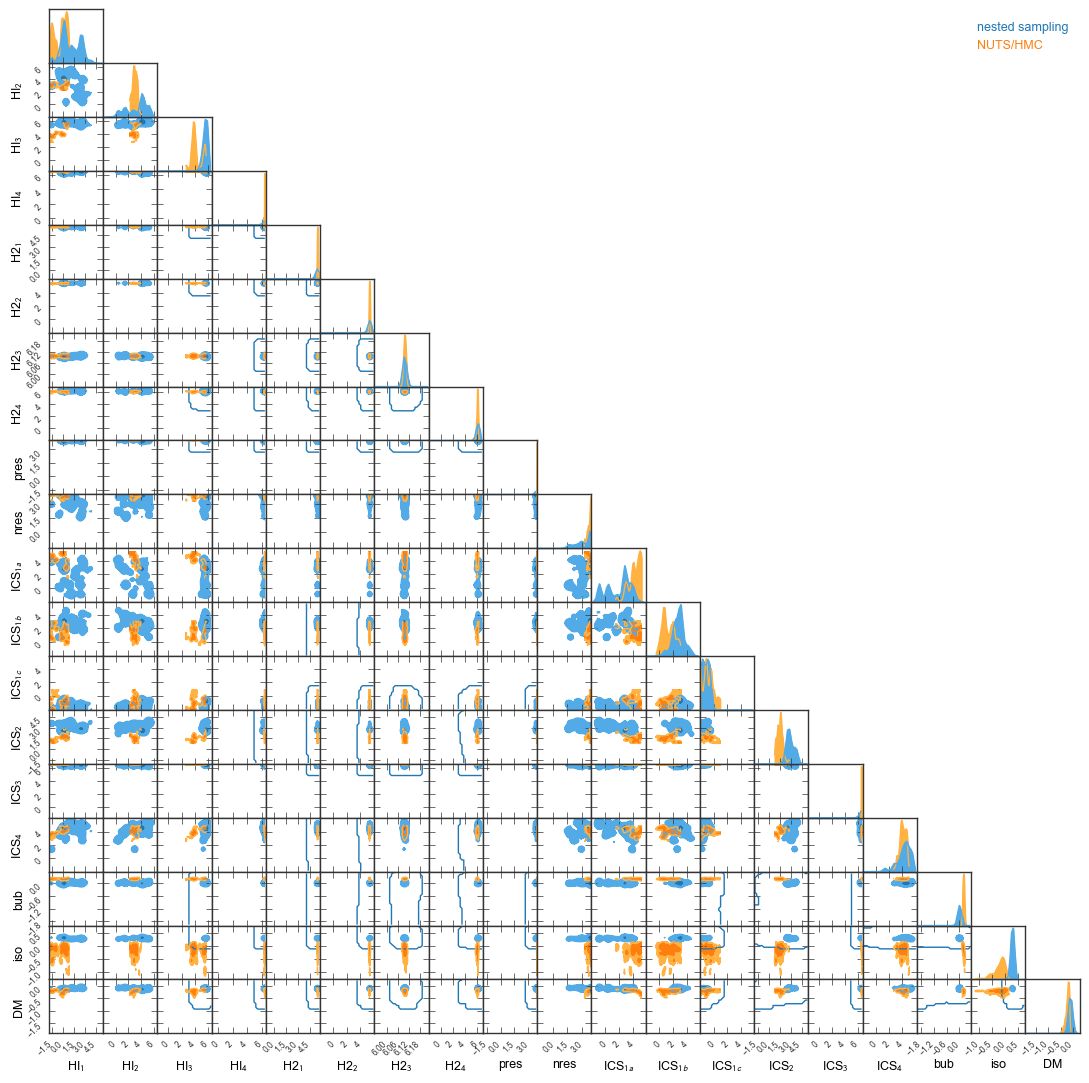

In [22]:
burn_in = sampler_dn.results.niter//3
pygtc.plotGTC(chains = [sampler_dn.results.samples[burn_in:], samples_nr],
              weights = [jnp.exp(sampler_dn.results.logl[burn_in:] - sampler_dn.results.logl.max()),
                         jnp.ones(len(samples_nr))],
              chainLabels = ['nested sampling', 'NUTS/HMC'],
              paramNames = names, #paramRanges = [list(x) for x in bounds[:-1]],
             )
plt.show()

the nested sampler results are broader, as expected